In [29]:
!pip install keras-tuner

In [30]:
# 1. Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras_tuner import Hyperband
import random

In [31]:
# 2. Preparing the dataset: Loading, splitting, and scaling features
# Load the Pima Indian Diabetes dataset
data = pd.read_csv('Pima Indian Diabetes dataset.csv')
X = data.iloc[:, :-1].values  # Features (8 columns)
y = data.iloc[:, -1].values   # Target variable (0 or 1)

# Split the dataset into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [32]:
# 3. Building a Neural Network model with Keras
def build_model(hp):
    model = Sequential()
    # Number of layers and units optimized by Hyperband and Genetic Algorithm
    for i in range(hp.Int('num_layers', 1, 4)):  # Number of layers (Hyperband and GA)
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32), activation='relu'))  # Units in each layer (GA and Hyperband)
        model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))  # Dropout rate (GA and Hyperband)

    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),  # Learning rate (GA and Hyperband)
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [33]:
# 4. Optimizing model hyperparameters with Keras Tuner Hyperband
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='hyperband_dir',
    project_name='diabetes_optimization'
)

tuner.search(X_train, y_train, epochs=20, validation_split=0.2, verbose=1)

# Genetic Algorithm Optimization for Hyperparameters (GA Section)
# Implementing a Genetic Algorithm to optimize number of layers, units, dropout rate, and learning rate
# Population initialization: Randomly generate population
population_size = 10  # Number of individuals in each generation
generations = 5       # Number of generations
mutation_rate = 0.1   # Mutation rate

def create_individual():
    # Each individual represents a model with hyperparameters
    num_layers = random.randint(1, 4)  # Random number of layers
    units = [random.randint(32, 128) for _ in range(num_layers)]  # Random units per layer
    dropout_rate = [round(random.uniform(0.1, 0.5), 2) for _ in range(num_layers)]  # Random dropout rate
    learning_rate = random.uniform(1e-4, 1e-2)  # Random learning rate
    return (num_layers, units, dropout_rate, learning_rate)

# Fitness function: Evaluates how well a model with a given configuration performs
def fitness(individual):
    num_layers, units, dropout_rate, learning_rate = individual
    model = Sequential()
    for i in range(num_layers):
        model.add(Dense(units=units[i], activation='relu'))
        model.add(Dropout(rate=dropout_rate[i]))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=10, verbose=0, validation_split=0.2)
    val_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    return val_accuracy

# Genetic Algorithm - Evolving population
def evolve_population(population):
    # Evaluate fitness
    fitness_scores = [fitness(individual) for individual in population]
    sorted_population = [x for _, x in sorted(zip(fitness_scores, population), reverse=True)]

    # Selection: Top 50% of the population
    selected_individuals = sorted_population[:population_size // 2]

    # Crossover: Combine two individuals to produce offspring
    offspring = []
    for i in range(len(selected_individuals) // 2):
        parent1, parent2 = selected_individuals[2 * i], selected_individuals[2 * i + 1]
        child = crossover(parent1, parent2)
        offspring.append(child)

    # Mutation: Apply mutation to offspring
    for i in range(len(offspring)):
        if random.random() < mutation_rate:
            offspring[i] = mutate(offspring[i])

    # New population is the best individuals + offspring
    population[:] = sorted_population[:population_size // 2] + offspring

# Crossover function: Mixing two parent solutions to create a child
def crossover(parent1, parent2):
    # Randomly select number of layers from either parent
    num_layers = random.choice([parent1[0], parent2[0]])
    # Ensure units and dropout_rate are consistent with num_layers
    units = [random.randint(32, 128) for _ in range(num_layers)]
    dropout_rate = [round(random.uniform(0.1, 0.5), 2) for _ in range(num_layers)]
    # Randomly choose learning rate
    learning_rate = random.choice([parent1[3], parent2[3]])
    return (num_layers, units, dropout_rate, learning_rate)


# Mutation function: Slightly change a random individual's configuration

def mutate(individual):
    num_layers, units, dropout_rate, learning_rate = individual
    mutation_choice = random.randint(0, 3)
    if mutation_choice == 0:  # Mutate number of layers
        num_layers = random.randint(1, 4)
        # Adjust units and dropout_rate based on new num_layers
        units = [random.randint(32, 128) for _ in range(num_layers)]
        dropout_rate = [round(random.uniform(0.1, 0.5), 2) for _ in range(num_layers)]
    elif mutation_choice == 1:  # Mutate units
        units = [random.randint(32, 128) for _ in range(num_layers)]
    elif mutation_choice == 2:  # Mutate dropout rate
        dropout_rate = [round(random.uniform(0.1, 0.5), 2) for _ in range(num_layers)]
    else:  # Mutate learning rate
        learning_rate = random.uniform(1e-4, 1e-2)

    return (num_layers, units, dropout_rate, learning_rate)

# Initialize population and evolve
population = [create_individual() for _ in range(population_size)]
for gen in range(generations):
    evolve_population(population)

Reloading Tuner from hyperband_dir/diabetes_optimization/tuner0.json


In [34]:
# 5. Model evaluation and performance metrics
best_individual = population[0]
print(f"Best configuration found by GA: {best_individual}")

# Extract the hyperparameters from the best individual
num_layers, units, dropout_rate, learning_rate = best_individual

# Build the model using the extracted hyperparameters
best_model = Sequential()
for i in range(num_layers):
    best_model.add(Dense(units=units[i], activation='relu'))
    best_model.add(Dropout(rate=dropout_rate[i]))
best_model.add(Dense(1, activation='sigmoid'))
best_model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Make predictions on the test data
y_pred = best_model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to class labels (0 or 1)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
auc = roc_auc_score(y_test, y_pred)

# Print the performance metrics
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {auc:.4f}")

Best configuration found by GA: (2, [33, 95], [0.24, 0.42], 0.005189889912376392)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Accuracy: 0.3506, Precision: 0.3228, Recall: 0.7455, AUC: 0.3960


In [35]:
!pip install plotly
import plotly.express as px

# ... (Your existing code to get top_hyperparams) ...

# Prepare data for plotting
hyperparam_data = []
for i, hp in enumerate(top_hyperparams):
    hyperparam_data.append({
        'Model': i + 1,
        'Layers': hp.get('num_layers'),
        'Units': hp.get('units_0'),
        'Learning Rate': hp.get('learning_rate')
    })

# Create a 3D scatter plot
fig = px.scatter_3d(
    hyperparam_data,
    x='Layers',
    y='Units',
    z='Learning Rate',
    color='Model',
    title='Top Hyperparameter Configurations'
)
fig.show()

In [14]:
# 7. Hyperparameters and corresponding validation accuracy for each trial
trials = tuner.oracle.get_best_trials(num_trials=10)
for trial in trials:
    print(f"Trial {trial.trial_id}: Val Accuracy = {trial.metrics.get_last_value('val_accuracy')}")


Trial 0001: Val Accuracy = 0.7804877758026123
Trial 0020: Val Accuracy = 0.7804877758026123
Trial 0002: Val Accuracy = 0.772357702255249
Trial 0014: Val Accuracy = 0.772357702255249
Trial 0016: Val Accuracy = 0.772357702255249
Trial 0011: Val Accuracy = 0.772357702255249
Trial 0028: Val Accuracy = 0.772357702255249
Trial 0024: Val Accuracy = 0.7642276287078857
Trial 0008: Val Accuracy = 0.7642276287078857
Trial 0025: Val Accuracy = 0.7642276287078857


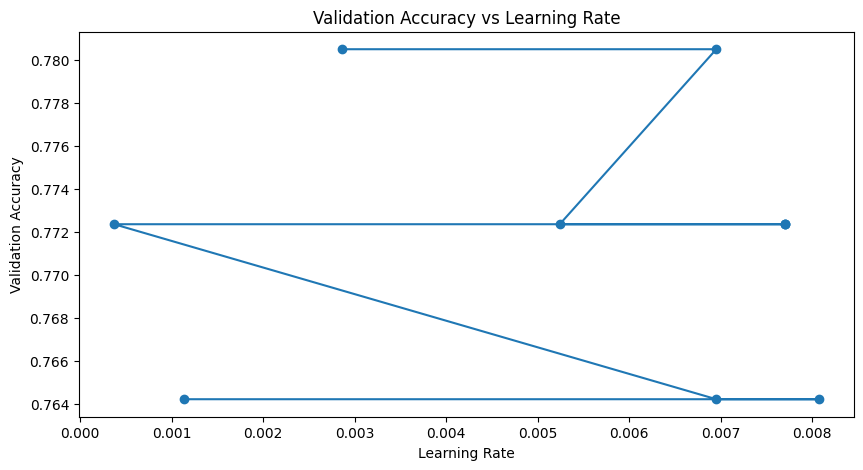

In [16]:
# 8. Validation accuracy vs learning rate
# Get learning rates for each trial (should match the number of trials)
learning_rates = [trial.hyperparameters.get('learning_rate') for trial in trials]
accuracies = [trial.metrics.get_last_value('val_accuracy') for trial in trials]

plt.figure(figsize=(10, 5))
plt.plot(learning_rates, accuracies, 'o-')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Learning Rate')
plt.show()

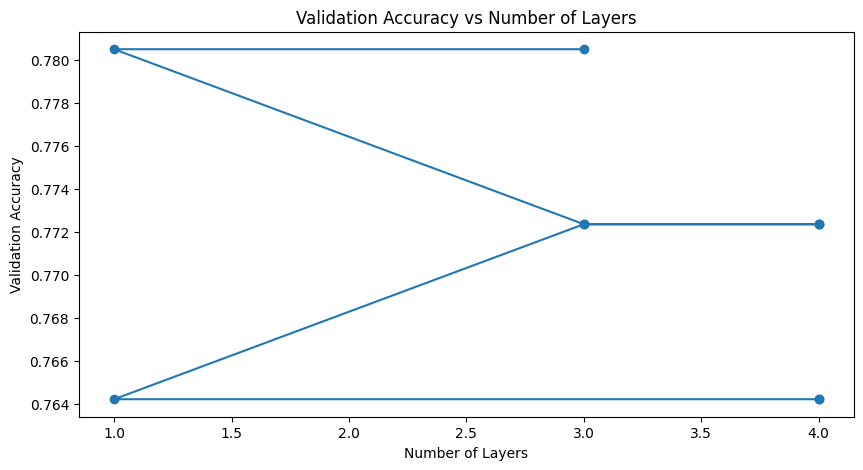

In [18]:
# 9. Validation accuracy vs number of layers
# Get learning rates for each trial (should match the number of trials)
layers = [trial.hyperparameters.get('num_layers') for trial in trials] # Get layers for each trial
accuracies = [trial.metrics.get_last_value('val_accuracy') for trial in trials]

plt.figure(figsize=(10, 5))
plt.plot(layers, accuracies, 'o-')
plt.xlabel('Number of Layers')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Number of Layers')
plt.show()

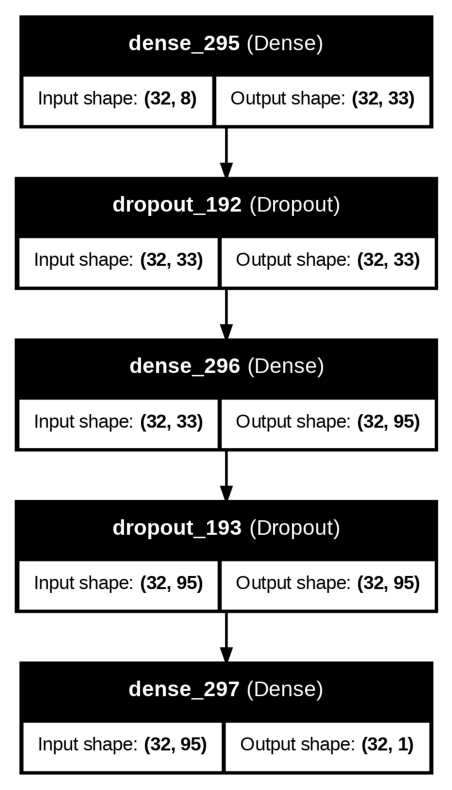

In [38]:
# 10. Layer representation
!pip install pydot
!pip install graphviz
from keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Assuming 'best_model' is your best model from the Hyperband tuning
plot_model(best_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Display the image
img = mpimg.imread('model_plot.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

1/5 ━━━━━━━━━━━━━━━━━━━━ 2s 526ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


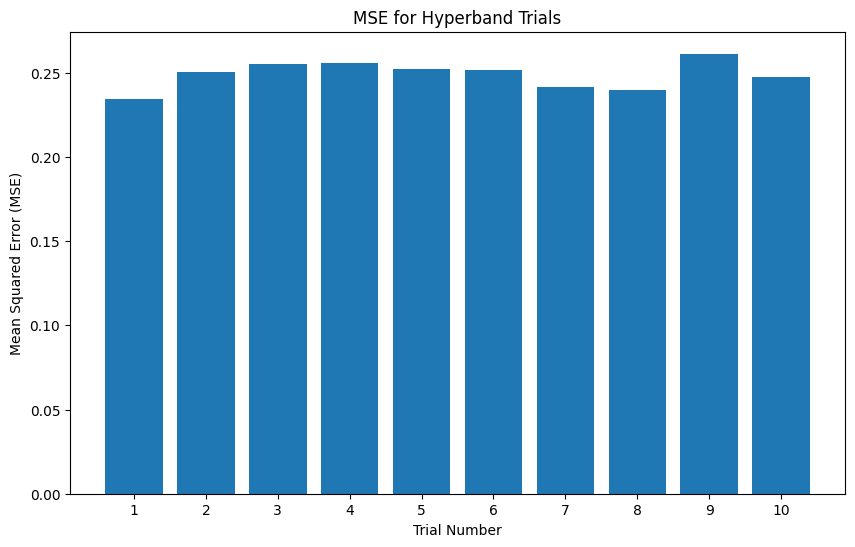

In [37]:
# 11. Collecting Mean Squared Error for Hyperband trials
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# ... (Your existing code for Hyperband tuning) ...

# Get MSE for each trial
mses = []
for trial in trials:  # Assuming 'trials' is the list of trials from Hyperband
    # Rebuild the model for this trial
    model = tuner.hypermodel.build(trial.hyperparameters)
    # Train the model (if necessary) - depends on your Hyperband setup
    # If Hyperband already trained the models, skip this step
    # model.fit(X_train, y_train, ...)

    y_pred = model.predict(X_test)  # Get predictions for this trial's model
    mse = mean_squared_error(y_test, y_pred)
    mses.append(mse)

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(trials) + 1), mses)
plt.xlabel('Trial Number')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Hyperband Trials')
plt.xticks(range(1, len(trials) + 1))  # Set x-axis ticks to trial numbers
plt.show()

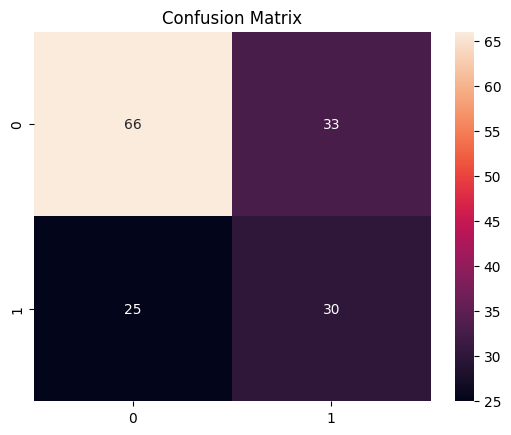

In [22]:
# 12. Precision, Recall, and AUC-ROC
import numpy as np
from sklearn.metrics import confusion_matrix

# Convert y_pred to binary predictions using a threshold (e.g., 0.5)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)  # Adjust threshold if necessary

conf_matrix = confusion_matrix(y_test, y_pred_binary)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7777 - loss: 0.4649 - val_accuracy: 0.7724 - val_loss: 0.4463
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7903 - loss: 0.4554 - val_accuracy: 0.7642 - val_loss: 0.4490
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7508 - loss: 0.5114 - val_accuracy: 0.7561 - val_loss: 0.4521
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7624 - loss: 0.4747 - val_accuracy: 0.7724 - val_loss: 0.4518
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7915 - loss: 0.4395 - val_accuracy: 0.7642 - val_loss: 0.4560
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7946 - loss: 0.4546 - val_accuracy: 0.7480 - val_loss: 0.4569
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7719 - loss: 0.4474 - val_accuracy: 0.7642 - val_loss: 0.4553
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7906 - loss: 0.4321 - val_accuracy: 0.7642 - val_loss

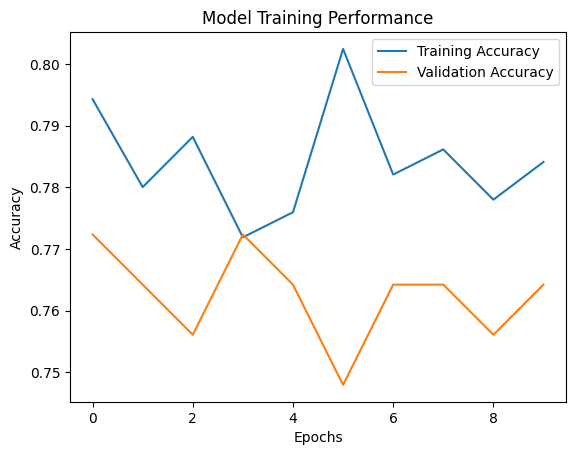

In [26]:
# 13. Model training performance visualization
# Assuming 'best_model' is a trained Keras/TensorFlow model
# Include validation_split or validation_data for validation metrics
history = best_model.fit(X_train, y_train, epochs=10, validation_split=0.2)
# Alternatively, use validation_data=(X_val, y_val) if you have a separate validation set

# Rest of the code remains the same
# Check if 'accuracy' or 'acc' is present in the history keys
if 'accuracy' in history.history:
    accuracy_key = 'accuracy'
elif 'acc' in history.history:
    accuracy_key = 'acc'
else:
    raise KeyError("Neither 'accuracy' nor 'acc' found in history keys. "
                   "Ensure the model was compiled with the appropriate metrics.")

plt.plot(history.history[accuracy_key]) # Use the correct key for accuracy
plt.plot(history.history['val_' + accuracy_key]) # Use the correct key for validation accuracy
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.title('Model Training Performance')
plt.show()
